In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2")

In [326]:
# dont ignore the first line of the csv files. Keep variable as np array

def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

unwrapped_complex_names = read_names("data/complex_names.txt")
unwrapped_monomer_names = read_names("data/protein_names.txt")
unwrapped_cofactor_names = read_names("data/cofactor_names.txt")
unwrapped_element_names = read_names("data/element_ids.txt")
unwrapped_pathway_names = read_names("data/pathway_names.txt")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
pathway_ids = read_names("data/pathway_ids.txt")
aa_ids = read_names("data/amino_acid_ids.txt")

unwrapped_protein_names = np.concatenate([unwrapped_complex_names, unwrapped_monomer_names])
protein_ids = np.concatenate([complex_ids, monomer_ids])

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
W = read_matrix("data/W_matrix.csv", sparse=True)
W2 = read_matrix("data/W2_matrix.csv", sparse=True)
W1 = read_matrix("data/W1_matrix.csv", sparse=True)
A = read_matrix("data/A_matrix.csv")
Tree = read_matrix("data/tree_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")
total_counts = read_matrix("data/rich_counts.csv")
total_counts_anaero = read_matrix("data/anaerobic_counts.csv")
total_counts_big = read_matrix("data/rich_counts_big.csv")

monomer_masses = read_matrix("data/monomer_masses.csv").flatten()
monomer_areas = read_matrix("data/monomer_areas.csv").flatten()
complex_areas = read_matrix("data/complex_areas.csv").flatten()
protein_areas = np.concatenate([complex_areas, monomer_areas])

# Validation against 2001 ICP-MS data

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/cyrus/.pyenv/versions/viv-10/lib/py

<Axes: xlabel='Atoms/cell', ylabel='Count'>

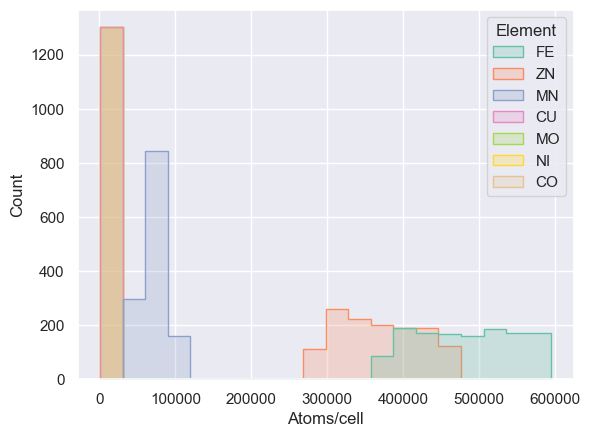

In [327]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")
sns.histplot(element_df, x="Atoms/cell", hue="Element", element="step")

# plt.xscale("log")

In [328]:
val_orig_df = pl.read_csv('external_data/distances.csv')

val_orig_df = val_orig_df.with_columns((   (-9* ( 1 - pl.col("Distance") / pl.col("ScaleDist")))  ).alias("Log concentration"))
val_orig_df = val_orig_df.with_columns(   (10**(pl.col("Log concentration"))).alias("Concentration (M)")  )
val_orig_df = val_orig_df.with_columns( (pl.col("Concentration (M)") *  (10**pl.col("ScaleCounts")) ).alias("Atoms/cell"))
val_orig_df

# filter out the elements
val_df = val_orig_df.filter(pl.col("Element").is_in(elements) & pl.col("Cell") == True)

# val_df = val_df.filter(pl.col("Condition") == "Rich")

val_df.to_pandas()

,Condition,Below LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log concentration,Concentration (M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1000.000000,-5.485784,3.267501e-06,3983.324414
1,Minimal,0,1,ZN,205.106947,354.00,9.08603,55212.922173,-3.785417,1.639017e-04,199808.236064
2,Minimal,0,1,CU,149.815832,354.00,9.08603,1000.000000,-5.191123,6.439870e-06,7850.676467
3,Minimal,1,1,NI,137.331179,354.00,9.08603,1000.000000,-5.508529,3.100778e-06,3780.077086
4,Minimal,1,1,CO,103.448109,354.00,9.08603,1000.000000,-6.369963,4.266155e-07,520.075813
5,Minimal,0,1,FE,203.321486,354.00,9.08603,24669.603524,-3.830810,1.476353e-04,179978.374255
6,Minimal,0,1,MN,135.088853,354.00,9.08603,1000.000000,-5.565538,2.719333e-06,3315.067378
7,Rich,0,1,MO,146.248788,353.14,9.30606,1000.000000,-5.272756,5.336351e-06,10797.032626
8,Rich,0,1,ZN,207.787945,353.14,9.30606,88105.726872,-3.704391,1.975192e-04,399640.415582
9,Rich,0,1,CU,181.919225,353.14,9.30606,29368.575624,-4.363672,4.328410e-05,87576.668290


## Estimate upper limit of atoms/cell available in media

In [329]:
media_lim_df = val_orig_df.filter(pl.col("Cell") == False)
media_lim_df = media_lim_df.filter(pl.col("Condition") == "Rich")

# to convert from atoms/cell in media, take the concentration in the media, convert to atoms by mult w avo, then divide by 3e11 cells per L
media_lim_df = media_lim_df.with_columns( (pl.col("Concentration (M)") * 6.022e23 / 3e11).alias("Limit atoms/cell"))

media_lim_df    

Condition,Below LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log concentration,Concentration (M),Atoms/cell,Limit atoms/cell
str,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""Rich""",0,0,"""MO""",97.206029,353.14,9.30606,1000.0,-6.522642,3.0016e-7,607.320802,602528.593969
"""Rich""",0,0,"""SE""",65.996332,353.14,9.30606,1000.0,-7.318041,4.8079e-8,97.278968,96511.365657
"""Rich""",0,0,"""ZN""",159.627693,353.14,9.30606,1000.0,-4.931786,0.000012,23674.150206,2.3487e7
"""Rich""",0,0,"""CU""",84.717286,353.14,9.30606,1000.0,-6.840925,1.4424e-7,291.83307,289530.292716
"""Rich""",0,0,"""NI""",80.258481,353.14,9.30606,1000.0,-6.954561,1.1103e-7,224.646162,222873.538725
"""Rich""",0,0,"""CO""",85.613691,353.14,9.30606,1000.0,-6.81808,1.5203e-7,307.595496,305168.340953
"""Rich""",0,0,"""FE""",146.251507,353.14,9.30606,1000.0,-5.272686,0.000005,10798.75537,1.0714e7
"""Rich""",0,0,"""MN""",86.505404,353.14,9.30606,1000.0,-6.795354,1.6019e-7,324.120016,321562.470481
"""Rich""",0,0,"""CR""",137.334075,353.14,9.30606,1000.0,-5.499953,0.000003,6398.927665,6.3484e6


## Final rich plot

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


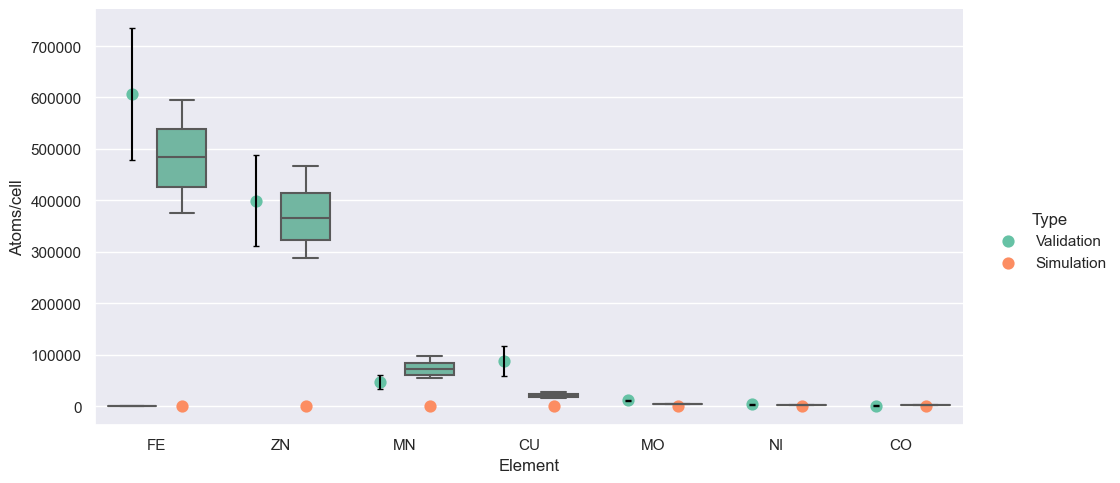

In [330]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")


# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(0).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(pl.lit("Simulation")).otherwise(pl.lit("Validation")).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=2, order=elements, join=False, dodge=.4, hue_order=["Validation", "Simulation"])

element_df = element_df.with_columns(Condition = pl.lit("Minimal"))
element_df = element_df.with_columns(Type = pl.lit("Simulation"))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": 0, "Condition": "Rich", "Type": "Validation"})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Rich") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=["Validation", "Simulation"])


# plt.yscale("log")

## Final minimal plot

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


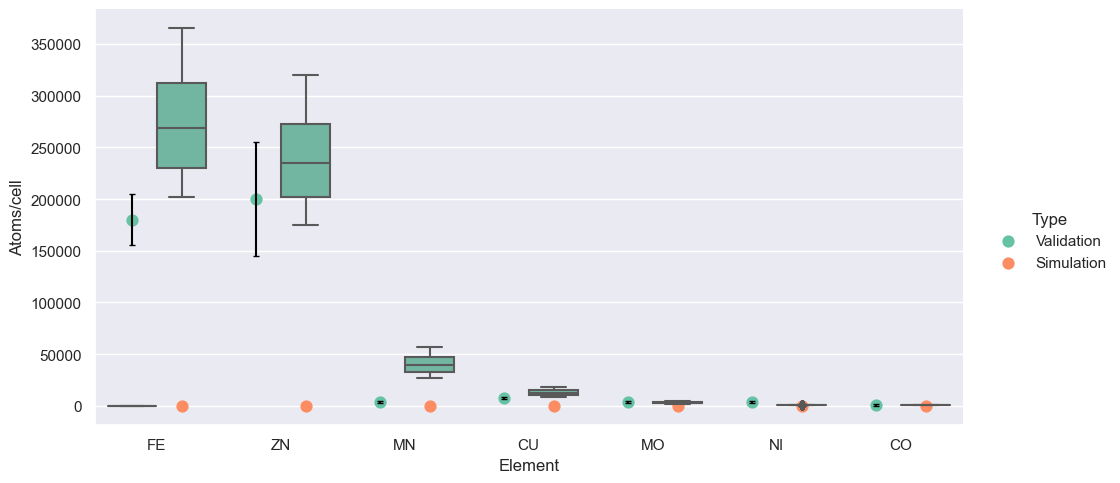

In [331]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts_min @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")


# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(0).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(pl.lit("Simulation")).otherwise(pl.lit("Validation")).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=2, order=elements, join=False, dodge=.4)

element_df = element_df.with_columns(Condition = pl.lit("Rich"))
element_df = element_df.with_columns(Type = pl.lit("Simulation"))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": 0, "Condition": "Minimal", "Type": "Validation"})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Minimal") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=["Validation", "Simulation"])

# plt.yscale("log")

In [332]:
val_df = pl.read_csv('external_data/distances.csv')

val_df = val_df.with_columns((   (-9* ( 1 - pl.col("Distance") / pl.col("ScaleDist")))  ).alias("Log concentration"))
val_df = val_df.with_columns(   (10**(pl.col("Log concentration"))).alias("Concentration (M)")  )
val_df = val_df.with_columns( (pl.col("Concentration (M)") *  (10**pl.col("ScaleCounts")) ).alias("Atoms/cell"))
val_df.to_pandas()

,Condition,Below LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log concentration,Concentration (M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1.000000e+03,-5.485784,3.267501e-06,3.983324e+03
1,Minimal,0,0,MO,49.938611,354.00,9.08603,1.000000e+03,-7.730374,1.860483e-08,2.268066e+01
2,Minimal,0,1,SE,118.604200,354.00,9.08603,1.000000e+03,-5.984639,1.036003e-06,1.262964e+03
3,Minimal,0,0,SE,57.079664,354.00,9.08603,1.000000e+03,-7.548822,2.826037e-08,3.445148e+01
4,Minimal,0,1,ZN,205.106947,354.00,9.08603,5.521292e+04,-3.785417,1.639017e-04,1.998082e+05
5,Minimal,0,0,ZN,82.480026,354.00,9.08603,1.000000e+03,-6.903050,1.250115e-07,1.523982e+02
6,Minimal,0,1,CU,149.815832,354.00,9.08603,1.000000e+03,-5.191123,6.439870e-06,7.850676e+03
7,Minimal,0,0,CU,70.449111,354.00,9.08603,1.000000e+03,-7.208921,6.181290e-08,7.535448e+01
8,Minimal,1,1,NI,137.331179,354.00,9.08603,1.000000e+03,-5.508529,3.100778e-06,3.780077e+03
9,Minimal,0,0,NI,50.830372,354.00,9.08603,1.000000e+03,-7.707702,1.960187e-08,2.389613e+01


# Single-cell data

In [440]:
sc_df = pl.read_csv('external_data/single_cell_fe.csv')

# remove the first row
# sc_df = sc_df.filter((pl.col("Bin") > 16) & (pl.col("Bin") < 60))

# create 1d list of all bins with comprehension
bins = sc_df["Bin"].to_numpy()
counts = sc_df["Count"].to_numpy()

# create a list with bin value repeated counts times
real_hist_data = np.repeat(bins, counts)

In [441]:
# compute the timeseries for the elements
big_element_timeseries = total_counts_big[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

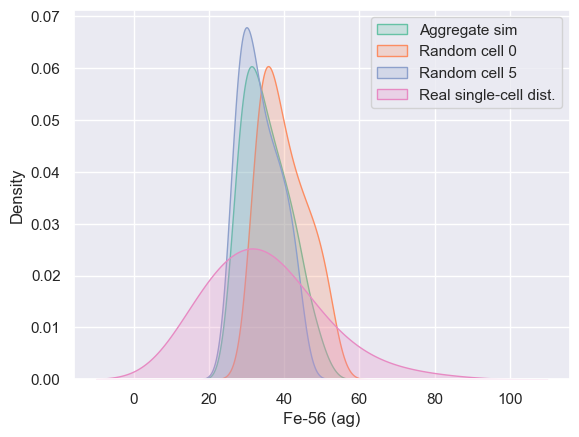

In [443]:
# filter FE 
big_fe_df = big_element_df.filter(pl.col("Element") == "FE")

# convert atoms/cell to float
big_fe_df = big_fe_df.with_columns( (big_fe_df["Atoms/cell"] * 55.85 * 10**18 * 0.92 / (6.023*10**23)).alias("Fe-56 (ag)"))

# create a weighted KDE plot 
sns.kdeplot(data=big_fe_df.to_pandas(), x="Fe-56 (ag)", weights="Density correction", fill=True, bw_adjust=2, label="Aggregate sim")

# plot single cell sim
sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == 0).to_pandas(), x="Fe-56 (ag)", 
            weights="Density correction", fill=True, bw_adjust=2, label="Random cell 0")
sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == 5).to_pandas(), x="Fe-56 (ag)", 
            weights="Density correction", fill=True, bw_adjust=2, label="Random cell 5")

# plot histogram data in sc_df, as lineplot with fill
sns.kdeplot(data=real_hist_data, fill=True, bw_adjust=2, label="Real single-cell dist.")

plt.legend()

In [444]:
[i for i in range(1, 16, 1)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]